FONCTIONS

In [301]:
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
# modèle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [302]:
def transfo_col_bool(df_films):

    df_films_not_bool = df_films.select_dtypes(exclude = 'bool')
    df_films_bool = df_films.select_dtypes(include = 'bool')
    df_films_bool = df_films_bool.astype(str)
    df_films_bool = df_films_bool.replace('True', '1').replace('False', '0')
    df_films_bool = df_films_bool.astype(int)
    df_films = pd.concat([df_films_not_bool, df_films_bool], axis = 1)
    df_films_not_bool, df_films_bool = 0, 0

    return df_films

In [303]:
def bool_colonne(df, df_recherche2, colonne):

    df[colonne] = df[colonne].astype(str)
    df[colonne] = df[colonne].apply(lambda x : x.replace('[', '').replace(']', '').replace("'", '').replace(", ", ","))
    df[colonne] = df[colonne].apply(lambda x : x.split(','))

    df_recherche2[colonne] = df_recherche2[colonne].astype(str)
    df_recherche2[colonne] = df_recherche2[colonne].apply(lambda x : x.replace('[', '').replace(']', '').replace("'", '').replace(", ", ","))
    df_recherche2[colonne] = df_recherche2[colonne].apply(lambda x : x.split(','))

    tous_les_genres = []

    for element in df_recherche2[colonne].iloc[0] :
        if colonne == 'acteur_out_KNN':
            if element in liste_acteurs_recurrents:
                tous_les_genres.append(element)
                tous_les_genres = list(set(tous_les_genres))
        elif colonne == 'realisateurs_out_KNN':
            if element in liste_realisateurs_recurrents:
                tous_les_genres.append(element)
                tous_les_genres = list(set(tous_les_genres))
        elif colonne == 'production_companies_name_out_KNN':
            if element in liste_production_recurrents:
                tous_les_genres.append(element)
        else:
            tous_les_genres.append(element)  

    for element2 in tous_les_genres:
        df[f'{colonne[0:-8]}_{element2}'] = df[f'{colonne}'].apply(lambda x: element2 in x)

    return df, tous_les_genres

In [304]:
# FONCTION 1

def encodage_X(X, type='standard'):
  from sklearn.preprocessing import StandardScaler
  index = X.index
  X_num = X.select_dtypes('number')
  X_cat = X.select_dtypes(exclude = 'number')

  if type == 'standard':
      from sklearn.preprocessing import StandardScaler
      SN = StandardScaler()
      X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

  else:
      from sklearn.preprocessing import MinMaxScaler
      SN = MinMaxScaler()
      X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

  X_num_SN = X_num_SN.mul(poids, axis = 1)
  X_cat_dummies = pd.get_dummies(X_cat)
  X_encoded = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

  X_encoded = X_encoded.dropna()

  return X_encoded, SN, X_num_SN, X_cat_dummies

# FONCTION 2

def evaluate_k(X_encoded, k_range):
    """
    Évalue différentes valeurs de k en utilisant la somme des distances aux voisins
    et le score de silhouette comme métriques.

    Args:
        X_encoded (DataFrame): Données normalisées
        k_range (range): Plage de valeurs de k à tester

    Returns:
        tuple: (distances moyennes, scores de silhouette)
    """
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans

    avg_distances = []
    silhouette_scores = []

    for k in k_range:
        # Calcul des distances moyennes pour chaque k
        from sklearn.neighbors import NearestNeighbors
        model = NearestNeighbors(n_neighbors=k)
        model.fit(X_encoded)
        distances, _ = model.kneighbors(X_encoded)
        avg_distances.append(np.mean(distances))

        # Calcul du score de silhouette
        # Nous utilisons KMeans pour créer des clusters et évaluer la qualité
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X_encoded)
        if k > 1:  # Le score de silhouette nécessite au moins 2 clusters
            silhouette_scores.append(silhouette_score(X_encoded, clusters))
        else:
            silhouette_scores.append(0)

    return avg_distances, silhouette_scores

# FONCTION 3

def encodage_predict(df_a_predire):
  X_num = df_a_predire.select_dtypes('number')
  X_cat = df_a_predire.select_dtypes(['object', 'category', 'string'])

  X_num_SN = pd.DataFrame(SN.transform(X_num), columns=X_num.columns).reset_index(drop=True)
  X_num_SN = X_num_SN.mul(poids, axis = 1)
  
  X_cat_dummies = pd.get_dummies(X_cat).reset_index(drop=True)
  X_encoded_predire = pd.concat([X_num_SN, X_cat_dummies], axis=1)

  df_predict = X_encoded_predire

  # DataFrame vide qui a les mêmes colonnes que X_encoded
  df_final = pd.DataFrame(columns=X_encoded.columns)

  # On veut que le DataFrame ait le même nombre de lignes que df_predict
  df_final = df_final.reindex(index=df_predict.index)
  # On met tous les NaN à False
  df_final = df_final.fillna(False)

  # On parcourt chaque colonne de df_predict
  # Si la colonne est présente dans X_encoded alors on la garde
  # Sinon, on la met à False
  for column in df_predict.columns:
    if column in X_encoded.columns:
      df_final[column] = df_predict[column]

  return df_final

# FONCTION 4

def pokemons_similaires(X, film_id):

  # Vérifier si le Pokémon existe dans le dataset
  if film_id not in X['film_id_out_KNN'].values:
      return f"Le Pokémon {film_id} n'est pas dans le dataset."

  # Récupérer les caractéristiques du Pokémon
  pokemon = X[X['film_id_out_KNN'] == film_id]

  # Je recopie ce qu'on a fait avant:
  caract_pokemon = X[X['film_id_out_KNN'] == film_id]

  caract_pokemon_encoded = encodage_predict(caract_pokemon)

  distances, indices = model.kneighbors(caract_pokemon_encoded)

  return df.iloc[indices[0]].reset_index(drop=True)

IMPORTS

In [305]:
# df = pd.read_csv('BD/P2_G5_films.csv.gz', compression = 'gzip', na_values = ['\\N'])
df = pd.read_csv('BD/P2_G5_films_essai_2.csv.gz', compression = 'gzip')
df_acteurs = df.copy()
df_realisateurs = df.copy()
df_acteurs_recurrents = df.copy()
df_realisateurs_recurrents = df.copy()
df_production_reccurent = df.copy()
df_recherche = df.copy()


In [306]:
df_acteurs_recurrents = pd.DataFrame(df_acteurs_recurrents['acteur_out_KNN'])
df_acteurs_recurrents['acteur_out_KNN'] = df_acteurs_recurrents['acteur_out_KNN'].astype(str)
df_acteurs_recurrents['acteur_out_KNN'] = df_acteurs_recurrents['acteur_out_KNN'].apply(lambda x : x.replace('[', '').replace(']', '').replace("'", '').replace(", ", ","))
df_acteurs_recurrents['acteur_out_KNN'] = df_acteurs_recurrents['acteur_out_KNN'].apply(lambda x : x.split(','))
df_acteurs_recurrents = df_acteurs_recurrents.explode('acteur_out_KNN')

df_acteurs_recurrents = pd.DataFrame(df_acteurs_recurrents.value_counts()).reset_index()
df_acteurs_recurrents = df_acteurs_recurrents[~(df_acteurs_recurrents['acteur_out_KNN'] == 'nan')]
limite_acteurs = 35
df_acteurs_recurrents = df_acteurs_recurrents[df_acteurs_recurrents['count'] >= limite_acteurs]

liste_acteurs_recurrents = df_acteurs_recurrents['acteur_out_KNN'].to_list()

In [307]:
df_realisateurs_recurrents = pd.DataFrame(df_realisateurs_recurrents['realisateurs_out_KNN'])
df_realisateurs_recurrents['realisateurs_out_KNN'] = df_realisateurs_recurrents['realisateurs_out_KNN'].astype(str)
df_realisateurs_recurrents['realisateurs_out_KNN'] = df_realisateurs_recurrents['realisateurs_out_KNN'].apply(lambda x : x.replace('[', '').replace(']', '').replace("'", '').replace(", ", ","))
df_realisateurs_recurrents['realisateurs_out_KNN'] = df_realisateurs_recurrents['realisateurs_out_KNN'].apply(lambda x : x.split(','))
df_realisateurs_recurrents = df_realisateurs_recurrents.explode('realisateurs_out_KNN')

df_realisateurs_recurrents = pd.DataFrame(df_realisateurs_recurrents.value_counts()).reset_index()
df_realisateurs_recurrents = df_realisateurs_recurrents[~(df_realisateurs_recurrents['realisateurs_out_KNN'] == 'nan')]
limite_realisateurs = 10
df_realisateurs_recurrents = df_realisateurs_recurrents[df_realisateurs_recurrents['count'] >= limite_realisateurs]

liste_realisateurs_recurrents = df_realisateurs_recurrents['realisateurs_out_KNN'].to_list()

In [308]:
df_production_reccurent = pd.DataFrame(df_production_reccurent['production_companies_name_out_KNN'])
df_production_reccurent['production_companies_name_out_KNN'] = df_production_reccurent['production_companies_name_out_KNN'].astype(str)
df_production_reccurent['production_companies_name_out_KNN'] = df_production_reccurent['production_companies_name_out_KNN'].apply(lambda x : x.replace('[', '').replace(']', '').replace("'", '').replace(", ", ","))
df_production_reccurent['production_companies_name_out_KNN'] = df_production_reccurent['production_companies_name_out_KNN'].apply(lambda x : x.split(','))
df_production_reccurent = df_production_reccurent.explode('production_companies_name_out_KNN')

df_production_reccurent = pd.DataFrame(df_production_reccurent.value_counts()).reset_index()
df_production_reccurent = df_production_reccurent[~(df_production_reccurent['production_companies_name_out_KNN'] == 'nan')]
limite_production = 35
df_production_reccurent = df_production_reccurent[df_production_reccurent['count'] >= limite_production]

liste_production_recurrents = df_production_reccurent['production_companies_name_out_KNN'].to_list()

FONCTION JONATHAN

FONCTIONS

In [309]:
df_recherche['title_out_KNN'] = df_recherche['title_out_KNN'].apply(lambda x : x.lower())
recherche = 'jurassic park'
recherche2 = recherche.lower().split(" ")

for element in recherche2:
    df_recherche2 = df_recherche[df_recherche['title_out_KNN'].str.contains(element)]
    df_recherche = df_recherche2

film_id = df_recherche2['film_id_out_KNN'].iloc[0]

In [310]:
# RECHERCHE DU TITRE

colonnes = ['acteur_', 'realisateurs_', 'genre_', 'production_companies_name_']
for element in colonnes:
    for element2 in df.columns:
        if element in element2:
            if 'out_KNN' not in element2:
                df = df.drop(element2, axis = 1)
    
df_recherche = df.copy()
df_recherche['title_out_KNN'] = df_recherche['title_out_KNN'].apply(lambda x : x.lower())
recherche = 'kill bill'
recherche2 = recherche.lower().split(" ")

for element in recherche2:
    df_recherche2 = df_recherche[df_recherche['title_out_KNN'].str.contains(element)]
    df_recherche = df_recherche2

film_id = df_recherche2['film_id_out_KNN'].iloc[0]
df_recherche2['title_out_KNN']

21310                     kill bill: vol. 1
28391    kill bill: the whole bloody affair
Name: title_out_KNN, dtype: object

In [311]:
for element in ['acteur_out_KNN', 'realisateurs_out_KNN', 'genre_out_KNN', 'production_companies_name_out_KNN']:
    df, tous_les_genres = bool_colonne(df, df_recherche2, element)
    if element == 'acteur_out_KNN':
        liste_acteurs = tous_les_genres
    elif element == 'realisateurs_out_KNN':
        liste_realisateurs = tous_les_genres

df['Decennie'] = df['Decennie'].apply(lambda x : int(x))
tous_les_genres = [df['Decennie'].iloc[0], df['Decennie'].iloc[0]+10, df['Decennie'].iloc[0]-10]
df['Decennie_critere'] = df['Decennie'].apply(lambda x: x in tous_les_genres)

df['arrondi_vote_exact'] = df['arrondi_vote_exact'].apply(lambda x : int(x))
tous_les_genres = [df['arrondi_vote_exact'].iloc[0], df['arrondi_vote_exact'].iloc[0]+1, df['arrondi_vote_exact'].iloc[0]-1]
df['arrondi_vote_exact_critere'] = df['arrondi_vote_exact'].apply(lambda x: x in tous_les_genres)

df = transfo_col_bool(df)

In [312]:
# CHOIX DES CARACTERISTIQUES

caracteristiques = []

for element in df.columns:
    if 'out_KNN' not in element:
        caracteristiques.append(element)

caracteristiques_num = []

for element in df.select_dtypes(include = 'number').columns:
    if 'out_KNN' not in element:
        caracteristiques_num.append(element)

# METTRE UNIQUEMENT POUR LES COLONNES NUMERIQUES

colonne_cle = 10
tres_important = 1
important = 1
bof = 1
rien = 0

poids = {
 'Decennie_critere' : colonne_cle,
 'arrondi_vote_exact_critere' : colonne_cle,
 'popularity' : colonne_cle,
 'year_exact' : important,
 'Decennie' : tres_important,
 'runtime_exact' : rien,
 'vote_exact' : important,
 'arrondi_vote_exact' : tres_important,
 'vote_count_mean' : important,
 'prod_US' : important,
 'prod_FR' : important
}

for element in df[caracteristiques_num].columns:
    if "production_companies_name" in element:
        poids.update({element : important})
    elif "acteur_" in element:
        poids.update({element : tres_important})
    elif "realisateurs_" in element:
        poids.update({element : tres_important})
    elif "genre_" in element:
        poids.update({element : colonne_cle})
    else:
        poids.update({element : rien})

# BASES

X = df[caracteristiques]

df_a_predire = df[df['film_id_out_KNN'] == film_id]
search = df_a_predire['title_out_KNN'].iloc[0]
# df_a_predire = df_a_predire.drop('title_len_out_KNN', axis = 1)
df_a_predire = df_a_predire[caracteristiques]

k_range = (3,5)

In [313]:
df_acteurs = df_acteurs[~(df_acteurs['film_id_out_KNN'] == film_id)]
df_acteurs['acteur_out_KNN'] = df_acteurs['acteur_out_KNN'].apply(lambda x : str(x))

if len(liste_acteurs) > 1:
    moyenne = 0
    rang = 0
    for n in range(len(liste_acteurs)):
        df_travail_acteur = df_acteurs[df_acteurs['acteur_out_KNN'].str.contains(liste_acteurs[n])].head(10)
        if df_travail_acteur.sort_values(by = 'vote_exact', ascending = False)['vote_exact'].head().mean() > moyenne:
            moyenne = df_acteurs.sort_values(by = 'vote_exact', ascending = False)['vote_exact'].head().mean()
            rang = n
        
    meilleur_acteur = liste_acteurs[rang]

else:
    meilleur_acteur = liste_acteurs[0]

df_meilleur_acteur = df_acteurs[df_acteurs['acteur_out_KNN'].str.contains(meilleur_acteur)]
df_meilleur_acteur = df_meilleur_acteur.sort_values(by = 'vote_exact', ascending = False)
df_meilleur_acteur = df_meilleur_acteur.head()

In [314]:
df_realisateurs = df_realisateurs[~(df_realisateurs['film_id_out_KNN'] == film_id)]
df_realisateurs['realisateurs_out_KNN'] = df_realisateurs['realisateurs_out_KNN'].apply(lambda x : str(x))

if len(liste_realisateurs) > 1:
    moyenne = 0
    rang = 0
    for n in range(len(liste_realisateurs)):
        df_travail_realisateur = df_realisateurs[df_realisateurs['realisateurs_out_KNN'].str.contains(liste_realisateurs[n])].head(10)
        if df_travail_realisateur.sort_values(by = 'vote_exact', ascending = False)['vote_exact'].head().mean() > moyenne:
            moyenne = df_realisateurs.sort_values(by = 'vote_exact', ascending = False)['vote_exact'].head().mean()
            rang = n
        
    meilleur_realisateur = liste_realisateurs[rang]

else:
    meilleur_realisateur = liste_realisateurs[0]

df_meilleur_realisateur = df_realisateurs[df_realisateurs['realisateurs_out_KNN'].str.contains(meilleur_realisateur)]
df_meilleur_realisateur = df_meilleur_realisateur.sort_values(by = 'vote_exact', ascending = False)
df_meilleur_realisateur = df_meilleur_realisateur.head()

In [48]:
# FONCTION 1

X_encoded, SN, X_num_SN, X_cat_dummies = encodage_X(X)

In [ ]:
# # FONCTION 2

avg_distances, silhouette_scores = evaluate_k(X_encoded, k_range)

In [ ]:
# # FONCTION 3

df_final = encodage_predict(df_a_predire)

In [157]:
# # FONCTION 4

# On choisit k
k=5

model = NearestNeighbors(n_neighbors=k, metric='euclidean')
model.fit(X_encoded)

NearestNeighbors(metric='euclidean')

In [158]:
caracteristiques.append('film_id_out_KNN')
resultat = pokemons_similaires(df[caracteristiques], film_id)
choix = pd.DataFrame(df[df['title_out_KNN'] == search])

# # choix2 = choix.drop(columns = choix.columns[22:])
# # resultat2 = resultat.drop(columns = resultat.columns[22:])

final = pd.concat([choix, resultat])
final = final.drop(0)

caracteristiques.remove('film_id_out_KNN')

final.transpose()

,25086,1,2,3,4
language_fr_out_KNN,1,1,1,1,1
popularity,1.781,0.653,9.211,20.174,11.175
year_exact,1997.0,2010.0,1948.0,2019.0,2007.0
Decennie,1990,2010,1940,2010,2000
runtime_exact,129.0,86.0,83.0,87.0,85.0
...,...,...,...,...,...
production_companies_name_Universal Pictures,1,0,1,0,0
production_companies_name_Digital Image Associates,1,0,0,0,0
production_companies_name_Amblin Entertainment,1,0,0,0,0
Decennie_critere,0,0,1,0,0


In [159]:
final['title_out_KNN']

25086            Le monde perdu: Jurassic Park
1                          Chercher le courant
2        Abbott & Costello Contre Frankenstein
3                           UglyDolls: Le film
4                       Naissance des pieuvres
Name: title_out_KNN, dtype: object

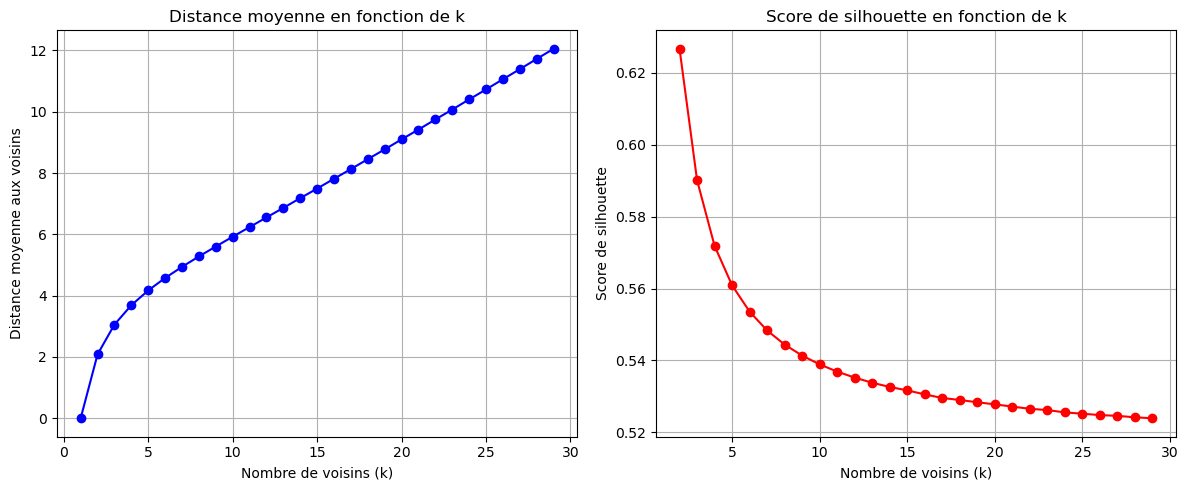

In [249]:
# Définition de la plage de k à tester

k_range = range(1,30)

# Évaluation des différentes valeurs de k
avg_distances, silhouette_scores = evaluate_k(X_encoded, k_range)

# Création d'une visualisation pour aider à choisir k
plt.figure(figsize=(12, 5))

# Premier graphique : Distance moyenne aux voisins
plt.subplot(1, 2, 1)
plt.plot(k_range, avg_distances, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Distance moyenne aux voisins')
plt.title('Distance moyenne en fonction de k')
plt.grid(True)

# Second graphique : Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'ro-')  # On commence à k=2
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction de k')
plt.grid(True)

plt.tight_layout()
plt.show()

In [250]:
# X_train, X_test, y_train, y_test = train_test_split(df_films.drop('title_out_KNN', axis=1), df_films['title_out_KNN'], test_size=0.75)

# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# param_grid = {"n_neighbors": range(20)}

# # Perform grid search with cross-validation
# gscv = GridSearchCV(model, param_grid, cv=5)
# gscv.fit(X_train, y_train)


# print("Best params:", gscv.best_params_)
# print("Best cross-validation score:", gscv.best_score_)

In [251]:
# df_films = df.copy()

# df_films['production_companies_name2'] = df_films['production_companies_name'].apply(lambda x: x.replace("[", '').replace("]", '').replace("'", ''))

# df_films['production_companies_name3'] = df_films['production_companies_name2'].apply(lambda x : x.split(','))

# tous_les_genres = set()
# tous_les_genres2 = set()

# for element in df_films['production_companies_name3']:
#   tous_les_genres.update(element)

# tous_les_genres_list = list(tous_les_genres)

# tous_les_genres_list.remove("")

# for n in range(len(tous_les_genres_list)):
#   tous_les_genres_list[n] = tous_les_genres_list[n].replace(" ","")

# tous_les_genres2_list = list(tous_les_genres2)
# tous_les_genres2_list.remove("")

# df_films['production_companies_name4'] = df_films['production_companies_name'].apply(lambda x: x.replace(" ", ''))

# new_dict = {}

# for element in tous_les_genres_list:
#     if len(df_films[df_films['production_companies_name2'].str.contains(element) == True]) >= 500:
#       new_dict.update({element : len(df_films[df_films['production_companies_name2'].str.contains(element) == True])})

# new_dict_sorted = dict(sorted(new_dict.items(), key=lambda x:x[1]))

# for genre in new_dict_sorted.keys():
#   df_films[f'production_companies_name_{genre}'] = df_films['production_companies_name4'].apply(lambda x: genre in x)

In [252]:
# df_LN = df[df['vote_count_mean'] != 0].drop(['adult', 'production_countries', 'status', 'tagline', 'production_companies_name', 'production_companies_country', 'titleType', 'region', 'Decennie', 'genre', 'final_language', 'popularity', 'year_exact', 'runtime_exact', 'vote_exact', 'arrondi_vote_exact', 'vote_count_mean'], axis = 1)
# df_LN_drop_NA = df_LN.dropna()
# X = df_LN_drop_NA
# y = pd.DataFrame(df_LN_drop_NA)

# def encodage_X(X, type='standard'):
#   X_num = X.select_dtypes('number')
#   X_cat = X.select_dtypes(['object', 'category', 'string'])
#   # Comme ça les dates, on n'y touche pas

#   if type == 'standard':
#     from sklearn.preprocessing import StandardScaler
#     SN = StandardScaler()
#     X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

#   else:
#     from sklearn.preprocessing import MinMaxScaler
#     SN = MinMaxScaler()
#     X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns)

#   X_cat_dummies = pd.get_dummies(X_cat)
#   X_encoded = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

#   return X_encoded, SN

# X_encoded, SN = encodage_X(X)

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.8)

# from sklearn.linear_model import LinearRegression

# modele = LinearRegression()

# modele.fit(X_train, y_train)

# print(f"Score d'entrainement {modele.score(X_train, y_train)}")
# print(f"Score de test {modele.score(X_test, y_test)}")

# df_a_predire = df_test[df_test['vote_count_mean'] == 0].drop(['isOriginalTitle', 'ordering', 'film_id', 'id', 'revenue', 'budget', 'backdrop_path', 'homepage', 'overview', 'poster_path', 'status', 'tagline', 'video', 'titleType', 'types', 'attributes'], axis = 1)
# df_a_predire = df_a_predire.drap('vote_count_mean', axis = 1)
# df_quelonveutpredire = df_a_predire.dropna()

# def encodage_predict(df_a_predire):
#   X_num = df_a_predire.select_dtypes('number')
#   X_cat = df_a_predire.select_dtypes(['object', 'category', 'string'])

#   X_num_SN = pd.DataFrame(SN.transform(X_num), columns=X_num.columns).reset_index(drop=True)

#   X_cat_dummies = pd.get_dummies(X_cat).reset_index(drop=True)
#   X_encoded_predire = pd.concat([X_num_SN.reset_index(), X_cat_dummies.reset_index()], axis=1)

#   df_predict = X_encoded_predire

#   # DataFrame vide qui a les mêmes colonnes que X_encoded
#   df_final = pd.DataFrame(columns=X_encoded.columns)

#   # On veut que le DataFrame ait le même nombre de lignes que df_predict
#   df_final = df_final.reindex(index=df_predict.index)
#   # On met tous les NaN à False
#   df_final = df_final.fillna(False)

#   # On parcourt chaque colonne de df_predict
#   # Si la colonne est présente dans X_encoded alors on la garde
#   # Sinon, on la met à False
#   for column in df_predict.columns:
#     if column in X_encoded.columns:
#       df_final[column] = df_predict[column]

#   return df_final

# df_pour_prediction = encodage_predict(df_quelonveutpredire)

# df_quelonveutpredire['prediction'] = modele.predict(df_pour_prediction)
# df_quelonveutpredire
